In [1]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
3.14.4


In [2]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [3]:
bdt_vars = [
    "nue_score",
    "numu_score",
    "numu_cc_flag"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum"
]

pf_eval_data_variables_no_pf_info = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]


In [4]:
wc_file_location = "/data1/hagaman/xin_files/processed_checkout_rootfiles/" # training events removed

In [5]:
#f_intrinsic_nue_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run1_PF.root")["wcpselection"]
#print(f_intrinsic_nue_run1.keys())
#f_intrinsic_nue_run1["T_BDTvars"].show()

In [6]:
# loading WC nue overlay files

f_intrinsic_nue_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run1_PF.root")["wcpselection"]
f_intrinsic_nue_run1_bdt = f_intrinsic_nue_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run1_eval = f_intrinsic_nue_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run1_pfeval = f_intrinsic_nue_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run1_kine = f_intrinsic_nue_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run1_pot = f_intrinsic_nue_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run1_POT = np.sum(f_intrinsic_nue_run1_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run1_df = pd.concat([f_intrinsic_nue_run1_bdt, f_intrinsic_nue_run1_eval, f_intrinsic_nue_run1_pfeval, f_intrinsic_nue_run1_kine], axis=1, sort=False)
del f_intrinsic_nue_run1
del f_intrinsic_nue_run1_bdt
del f_intrinsic_nue_run1_eval
del f_intrinsic_nue_run1_pfeval
del f_intrinsic_nue_run1_kine
del f_intrinsic_nue_run1_pot
intrinsic_nue_run1_df["isEXT"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["isDirt"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["WC_file"] = ["intrinsic_nue_run1" for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["run_num"] = [1 for i in range(intrinsic_nue_run1_df.shape[0])]

f_intrinsic_nue_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run2_PF.root")["wcpselection"]
f_intrinsic_nue_run2_bdt = f_intrinsic_nue_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run2_eval = f_intrinsic_nue_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run2_pfeval = f_intrinsic_nue_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run2_kine = f_intrinsic_nue_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run2_pot = f_intrinsic_nue_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run2_POT = np.sum(f_intrinsic_nue_run2_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run2_df = pd.concat([f_intrinsic_nue_run2_bdt, f_intrinsic_nue_run2_eval, f_intrinsic_nue_run2_pfeval, f_intrinsic_nue_run2_kine], axis=1, sort=False)
del f_intrinsic_nue_run2
del f_intrinsic_nue_run2_bdt
del f_intrinsic_nue_run2_eval
del f_intrinsic_nue_run2_pfeval
del f_intrinsic_nue_run2_kine
del f_intrinsic_nue_run2_pot
intrinsic_nue_run2_df["isEXT"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["isDirt"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["WC_file"] = ["intrinsic_nue_run2" for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["run_num"] = [2 for i in range(intrinsic_nue_run2_df.shape[0])]

f_intrinsic_nue_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run3_PF.root")["wcpselection"]
f_intrinsic_nue_run3_bdt = f_intrinsic_nue_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run3_eval = f_intrinsic_nue_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run3_pfeval = f_intrinsic_nue_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run3_kine = f_intrinsic_nue_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run3_pot = f_intrinsic_nue_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run3_POT = np.sum(f_intrinsic_nue_run3_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run3_df = pd.concat([f_intrinsic_nue_run3_bdt, f_intrinsic_nue_run3_eval, f_intrinsic_nue_run3_pfeval, f_intrinsic_nue_run3_kine], axis=1, sort=False)
del f_intrinsic_nue_run3
del f_intrinsic_nue_run3_bdt
del f_intrinsic_nue_run3_eval
del f_intrinsic_nue_run3_pfeval
del f_intrinsic_nue_run3_kine
del f_intrinsic_nue_run3_pot
intrinsic_nue_run3_df["isEXT"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["isDirt"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["WC_file"] = ["intrinsic_nue_run3" for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["run_num"] = [3 for i in range(intrinsic_nue_run3_df.shape[0])]

print(intrinsic_nue_run1_POT, intrinsic_nue_run2_POT, intrinsic_nue_run3_POT)
print(intrinsic_nue_run1_df.shape[0], intrinsic_nue_run2_df.shape[0], intrinsic_nue_run3_df.shape[0])

intrinsic_nue_df = pd.concat([intrinsic_nue_run1_df, intrinsic_nue_run2_df, intrinsic_nue_run3_df], sort=False).query(
    "truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0")

del intrinsic_nue_run1_df
del intrinsic_nue_run2_df
del intrinsic_nue_run3_df


3.931094470783121e+22 1.2460289446544576e+23 8.821478522260567e+22
68206 209160 148962


In [7]:
# loading WC nu overlay files

f_nu_overlay_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

print(nu_overlay_run1_POT, nu_overlay_run2_POT, nu_overlay_run3_POT)
print(nu_overlay_run1_df.shape[0], nu_overlay_run2_df.shape[0], nu_overlay_run3_df.shape[0])

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False).query(
    "not (truth_isCC==1 and abs(truth_nuPdg)==12) and kine_reco_Enu > 0")
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df

7.145731450157032e+20 9.12249070351224e+20 7.058722964792489e+20
581941 727871 562728


In [8]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

numu_and_nue_df = pd.concat([overlay_df, intrinsic_nue_df], sort=False)

del overlay_df
del intrinsic_nue_df


In [9]:
# adding truth primary particle nums, only for numu and nue

num_prim_photons = []
num_prim_protons = []
num_prim_nonprim_protons = []
num_prim_charged_pions = []
num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []
num_prim_pi0s = []
num_prim_others = []

max_proton_true_kinetic_energies = []
max_pion_true_kinetic_energies = []

photon_thetas = []
photon_phis = []
photon_energies = []

runnum = numu_and_nue_df["run_num"].to_numpy()
run = numu_and_nue_df["run"].to_numpy()
subrun = numu_and_nue_df["subrun"].to_numpy()
event = numu_and_nue_df["event"].to_numpy()

truth_pdgs = numu_and_nue_df["truth_pdg"].to_numpy()
truth_mothers = numu_and_nue_df["truth_mother"].to_numpy()
truth_startMomentums = numu_and_nue_df["truth_startMomentum"].to_numpy()

for i in tqdm(range(numu_and_nue_df.shape[0])):
    #for i in tqdm(range(10)):
    #print("new event")

    num_prim_nonprim_proton = 0
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]

    for j in range(len(truth_pdg_list)):
        if truth_pdg_list[j] == 2212:
            #print(truth_startMomentum_list[j][3] * 1000. - 938.272)
            if truth_startMomentum_list[j][3] * 1000. - 938.272 > 35.:
                num_prim_nonprim_proton += 1

    num_prim_nonprim_protons.append(num_prim_nonprim_proton)

numu_and_nue_df["num_prim_nonprim_protons"] = num_prim_nonprim_protons


100%|█████████████████████████████████| 973577/973577 [01:54<00:00, 8488.88it/s]


In [10]:
# loading WC EXT files

#f_ext_run1 = uproot.open(wc_file_location + "wcp_data_extbnb_run1_mcc9_v08_00_00_53_checkout.root")["wcpselection"] # has wrong POT info
f_ext_run1 = uproot.open(wc_file_location + "checkout_data_extbnb_run1_PF.root")["wcpselection"]
f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run1
del f_ext_run1_bdt
del f_ext_run1_eval
del f_ext_run1_pfeval
del f_ext_run1_kine
del f_ext_run1_pot
ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

f_ext_run2 = uproot.open(wc_file_location + "checkout_data_extbnb_run2_PF.root")["wcpselection"]
f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run2
del f_ext_run2_bdt
del f_ext_run2_eval
del f_ext_run2_pfeval
del f_ext_run2_kine
del f_ext_run2_pot
ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

f_ext_run3 = uproot.open(wc_file_location + "checkout_data_extbnb_run3_PF.root")["wcpselection"]
f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run3
del f_ext_run3_bdt
del f_ext_run3_eval
del f_ext_run3_pfeval
del f_ext_run3_kine
del f_ext_run3_pot
ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

print(ext_run1_POT, ext_run2_POT, ext_run3_POT)
print(ext_run1_df.shape[0], ext_run2_df.shape[0], ext_run3_df.shape[0])

ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False)
del ext_run1_df
del ext_run2_df
del ext_run3_df

# fixing POTs, from lee_fit configurations/cv_input.txt, technically using different files but I think it should be pretty much the same.
# pot_counting didn't work, pot_counting_mc gave way too low numbers.
ext_run1_POT = 2.21814e+20
ext_run2_POT = 6.25014e+20
ext_run3_POT = 7.4127e+20

print("\nfixed:")
print(ext_run1_POT, ext_run2_POT, ext_run3_POT)



84730946.0921828 289727438.0184046 0.0
9984 28818 33066

fixed:
2.21814e+20 6.25014e+20 7.4127e+20


In [11]:
# loading WC dirt files

f_dirt_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
del f_dirt_run1
del f_dirt_run1_bdt
del f_dirt_run1_eval
del f_dirt_run1_pfeval
del f_dirt_run1_kine
del f_dirt_run1_pot
dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

f_dirt_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
del f_dirt_run2
del f_dirt_run2_bdt
del f_dirt_run2_eval
del f_dirt_run2_pfeval
del f_dirt_run2_kine
del f_dirt_run2_pot
dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

f_dirt_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
del f_dirt_run3
del f_dirt_run3_bdt
del f_dirt_run3_eval
del f_dirt_run3_pfeval
del f_dirt_run3_kine
del f_dirt_run3_pot
dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]

print(dirt_run1_POT, dirt_run2_POT, dirt_run3_POT)
print(dirt_run1_df.shape[0], dirt_run2_df.shape[0], dirt_run3_df.shape[0])

dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False).query("kine_reco_Enu > 0")
del dirt_run1_df
del dirt_run2_df
del dirt_run3_df

1.0014303040723798e+21 7.510164458534727e+20 1.0949426713304372e+21
332957 244620 356204


In [12]:
# full data

em_charge_scale = 0.95

f_data_run1 = uproot.open(wc_file_location + "checkout_data_bnb_run1_PF.root")["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine
data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["WC_file"] = ["data_run1" for i in range(data_run1_df.shape[0])]
data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

f_data_run2 = uproot.open(wc_file_location + "checkout_data_bnb_run2_PF.root")["wcpselection"]
f_data_run2_bdt = f_data_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run2_eval = f_data_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run2_pfeval = f_data_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run2_kine = f_data_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run2_df = pd.concat([f_data_run2_bdt, f_data_run2_eval, f_data_run2_pfeval, f_data_run2_kine], axis=1, sort=False)
del f_data_run2
del f_data_run2_bdt
del f_data_run2_eval
del f_data_run2_pfeval
del f_data_run2_kine
data_run2_df["isEXT"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["isDirt"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["WC_file"] = ["data_run2" for i in range(data_run2_df.shape[0])]
data_run2_df["category"] = ["data" for i in range(data_run2_df.shape[0])]
data_run2_df["run_num"] = [2 for i in range(data_run2_df.shape[0])]

f_data_run3 = uproot.open(wc_file_location + "checkout_data_bnb_run3_PF.root")["wcpselection"]
f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
del f_data_run3
del f_data_run3_bdt
del f_data_run3_eval
del f_data_run3_pfeval
del f_data_run3_kine
data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["WC_file"] = ["data_run3" for i in range(data_run3_df.shape[0])]
data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]


data_all_df = pd.concat([data_run1_df, data_run2_df, data_run3_df], sort=False).query("kine_reco_Enu > 0")

del data_run1_df
del data_run2_df
del data_run3_df

In [13]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

all_df = pd.concat([numu_and_nue_df, ext_df, dirt_df], sort=False)

del numu_and_nue_df
del ext_df
del dirt_df


In [14]:
normalizing_POT_run1 = 1.423e20
normalizing_POT_run2 = 2.541e20
normalizing_POT_run3 = 2.405e20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)
truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()


run_nums = all_df["run_num"].to_numpy()
WC_file_str = all_df["WC_file"].to_numpy()
net_weights = []
for i in tqdm(range(len(weight_cv))):
    weight_temp = weight_cv[i] * weight_spline[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
        weight_temp = 1.
    if run_nums[i] == 1:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run1 / ext_run1_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run1 / dirt_run1_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run1 / intrinsic_nue_run1_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run1 / nu_overlay_run1_POT)
    elif run_nums[i] == 2:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run2 / ext_run2_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run2 / dirt_run2_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run2 / intrinsic_nue_run2_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run2 / nu_overlay_run2_POT)
    elif run_nums[i] == 3:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run3 / ext_run3_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run3 / dirt_run3_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run3 / intrinsic_nue_run3_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run3 / nu_overlay_run3_POT)
            
all_df["net_weight"] = net_weights

100%|█████████████████████████████| 1076591/1076591 [00:07<00:00, 142056.56it/s]


In [15]:
# adding proton and pion nums, adjusting em scale for reco_showerKE and kine_reco_Enu

proton_nums = []
track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    track_nums.append(track_num)
all_df["num_protons"] = proton_nums
all_df["num_other_tracks"] = track_nums


proton_nums = []
track_nums = []
corrected_kine_reco_Enus = []
energy_info_lists = data_all_df["kine_energy_info"].to_numpy()
energy_lists = data_all_df["kine_energy_particle"].to_numpy()
pdg_lists = data_all_df["kine_particle_type"].to_numpy()
add_energies = data_all_df["kine_reco_add_energy"].to_numpy()
for i in tqdm(range(data_all_df.shape[0])):
    proton_num = 0
    track_num = 0
    corrected_kine_reco_Enu = 0.
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    energy_info_list = energy_info_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
        if energy_info_list[j] == 2 and pdg_list[j] == 11:
            corrected_kine_reco_Enu += em_charge_scale * energy_list[j]
        else:
            corrected_kine_reco_Enu += energy_list[j]
    corrected_kine_reco_Enu += add_energies[i]
    
    corrected_kine_reco_Enus.append(corrected_kine_reco_Enu)        
    proton_nums.append(proton_num)
    track_nums.append(track_num)
data_all_df["num_protons"] = proton_nums
data_all_df["num_other_tracks"] = track_nums
data_all_df["kine_reco_Enu"] = corrected_kine_reco_Enus

uncorrected_reco_showerKE = all_df["reco_showerKE"].to_numpy()
all_df["reco_showerKE"] = uncorrected_reco_showerKE * 1000.

uncorrected_reco_showerKE = data_all_df["reco_showerKE"].to_numpy()
data_all_df["reco_showerKE"] = em_charge_scale * uncorrected_reco_showerKE * 1000.

100%|████████████████████████████████| 230733/230733 [00:12<00:00, 18225.11it/s]


In [16]:
nue_df = all_df.query("not (isDirt==1) and not (isEXT==1) and truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0 and nue_score > 7")

nue_FC_df = nue_df.query("match_isFC==1")
nue_PC_df = nue_df.query("match_isFC==0")

nue_true_0p_reco_0p_FC_df = nue_FC_df.query("num_prim_nonprim_protons==0 and num_protons==0")
nue_true_0p_reco_Np_FC_df = nue_FC_df.query("num_prim_nonprim_protons==0 and num_protons>0")
nue_true_Np_reco_0p_FC_df = nue_FC_df.query("num_prim_nonprim_protons>0 and num_protons==0")
nue_true_Np_reco_Np_FC_df = nue_FC_df.query("num_prim_nonprim_protons>0 and num_protons>0")

nue_true_0p_reco_0p_PC_df = nue_PC_df.query("num_prim_nonprim_protons==0 and num_protons==0")
nue_true_0p_reco_Np_PC_df = nue_PC_df.query("num_prim_nonprim_protons==0 and num_protons>0")
nue_true_Np_reco_0p_PC_df = nue_PC_df.query("num_prim_nonprim_protons>0 and num_protons==0")
nue_true_Np_reco_Np_PC_df = nue_PC_df.query("num_prim_nonprim_protons>0 and num_protons>0")

numu_df = all_df.query("not (isDirt==1) and not (isEXT==1) and truth_isCC==1 and abs(truth_nuPdg)==14 and kine_reco_Enu > 0 and numu_score > 0.9")

numu_FC_df = numu_df.query("match_isFC==1")
numu_PC_df = numu_df.query("match_isFC==0")

numu_true_0p_reco_0p_FC_df = numu_FC_df.query("num_prim_nonprim_protons==0 and num_protons==0")
numu_true_0p_reco_Np_FC_df = numu_FC_df.query("num_prim_nonprim_protons==0 and num_protons>0")
numu_true_Np_reco_0p_FC_df = numu_FC_df.query("num_prim_nonprim_protons>0 and num_protons==0")
numu_true_Np_reco_Np_FC_df = numu_FC_df.query("num_prim_nonprim_protons>0 and num_protons>0")

numu_true_0p_reco_0p_PC_df = numu_PC_df.query("num_prim_nonprim_protons==0 and num_protons==0")
numu_true_0p_reco_Np_PC_df = numu_PC_df.query("num_prim_nonprim_protons==0 and num_protons>0")
numu_true_Np_reco_0p_PC_df = numu_PC_df.query("num_prim_nonprim_protons>0 and num_protons==0")
numu_true_Np_reco_Np_PC_df = numu_PC_df.query("num_prim_nonprim_protons>0 and num_protons>0")


In [17]:
b = (60, 60)
r = ((0, 3000), (0, 3000))

res_FC_raw, xedges_, yedges_ = np.histogram2d(nue_FC_df["truth_nuEnergy"].to_numpy(), nue_FC_df["kine_reco_Enu"].to_numpy(), 
                                              weights=nue_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_PC_raw, xedges_, yedges_ = np.histogram2d(nue_PC_df["truth_nuEnergy"].to_numpy(), nue_PC_df["kine_reco_Enu"].to_numpy(), 
                                              weights=nue_PC_df["net_weight"].to_numpy(), bins=b, range=r)

nueCC_FC_res = []
nueCC_PC_res = []
for i in range(60):
    for j in range(60):
        nueCC_FC_res.append(res_FC_raw[i][j])
        nueCC_PC_res.append(res_PC_raw[i][j])

bin_centers_x = []
bin_centers_y = []
for i in range(60):
    for j in range(60):
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)
        
b = (60, 60)
r = ((0, 3000), (0, 3000))

print(np.max(nueCC_FC_res), np.max(nueCC_PC_res))

1.672655336106101 0.5388897967135103


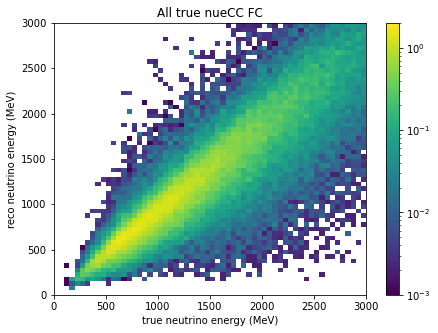

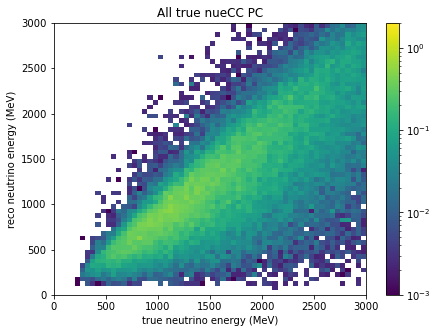

In [18]:
mpl.rcParams.update({'font.size': 10})

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_FC_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy (MeV)")
plt.ylabel("reco neutrino energy (MeV)")
plt.title("All true nueCC FC")
plt.show()

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_PC_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy (MeV)")
plt.ylabel("reco neutrino energy (MeV)")
plt.title("All true nueCC PC")
plt.show()

1.2511268174172232 0.3522581937983657


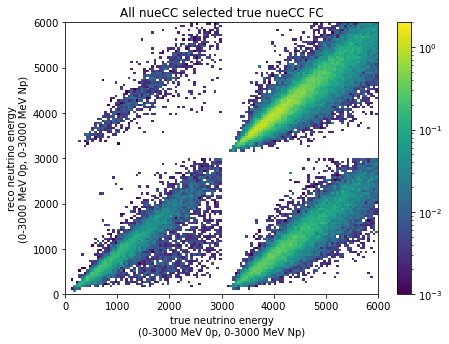

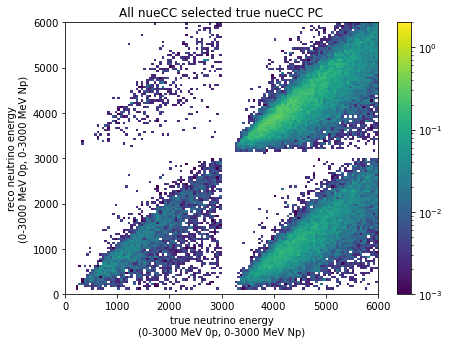

In [19]:
b = (60, 60)
r = ((0, 3000), (0, 3000))

res_true_0p_reco_0p_FC_raw, xedges_, yedges_ = np.histogram2d(nue_true_0p_reco_0p_FC_df["truth_nuEnergy"].to_numpy(), nue_true_0p_reco_0p_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_0p_reco_0p_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_0p_reco_Np_FC_raw, xedges_, yedges_ = np.histogram2d(nue_true_0p_reco_Np_FC_df["truth_nuEnergy"].to_numpy(), nue_true_0p_reco_Np_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_0p_reco_Np_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_0p_FC_raw, xedges_, yedges_ = np.histogram2d(nue_true_Np_reco_0p_FC_df["truth_nuEnergy"].to_numpy(), nue_true_Np_reco_0p_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_Np_reco_0p_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_Np_FC_raw, xedges_, yedges_ = np.histogram2d(nue_true_Np_reco_Np_FC_df["truth_nuEnergy"].to_numpy(), nue_true_Np_reco_Np_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_Np_reco_Np_FC_df["net_weight"].to_numpy(), bins=b, range=r)

res_true_0p_reco_0p_PC_raw, xedges_, yedges_ = np.histogram2d(nue_true_0p_reco_0p_PC_df["truth_nuEnergy"].to_numpy(), nue_true_0p_reco_0p_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_0p_reco_0p_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_0p_reco_Np_PC_raw, xedges_, yedges_ = np.histogram2d(nue_true_0p_reco_Np_PC_df["truth_nuEnergy"].to_numpy(), nue_true_0p_reco_Np_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_0p_reco_Np_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_0p_PC_raw, xedges_, yedges_ = np.histogram2d(nue_true_Np_reco_0p_PC_df["truth_nuEnergy"].to_numpy(), nue_true_Np_reco_0p_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_Np_reco_0p_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_Np_PC_raw, xedges_, yedges_ = np.histogram2d(nue_true_Np_reco_Np_PC_df["truth_nuEnergy"].to_numpy(), nue_true_Np_reco_Np_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=nue_true_Np_reco_Np_PC_df["net_weight"].to_numpy(), bins=b, range=r)

nueCC_FC_split_res = []
nueCC_PC_split_res = []
bin_centers_x = []
bin_centers_y = []

# true 0p reco 0p
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_0p_reco_0p_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_0p_reco_0p_PC_raw[i][j])
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)

# true 0p reco Np
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_0p_reco_Np_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_0p_reco_Np_PC_raw[i][j])
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append(3000. + (j + 0.5) / 60. * 3000.)
        
# true Np reco 0p
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_Np_reco_0p_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_Np_reco_0p_PC_raw[i][j])
        bin_centers_x.append(3000. + (i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)

# true Np reco Np
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_Np_reco_Np_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_Np_reco_Np_PC_raw[i][j])
        bin_centers_x.append(3000. + (i + 0.5) / 60. * 3000.)
        bin_centers_y.append(3000. + (j + 0.5) / 60. * 3000.)


print(np.max(nueCC_FC_split_res), np.max(nueCC_PC_split_res))

b = (120, 120)
r = ((0, 6000), (0, 6000))

mpl.rcParams.update({'font.size': 10})

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_FC_split_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.ylabel("reco neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.title("All nueCC selected true nueCC FC")
plt.savefig("plots/nue_FC_res.png", dpi=600)
plt.show()

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_PC_split_res, norm=mpl.colors.LogNorm(1e-3, 2))
plt.colorbar()
plt.xlabel("true neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.ylabel("reco neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.title("All nueCC selected true nueCC PC")
plt.savefig("plots/nue_PC_res.png", dpi=600)
plt.show()


290.4370552327421 252.04790806248502


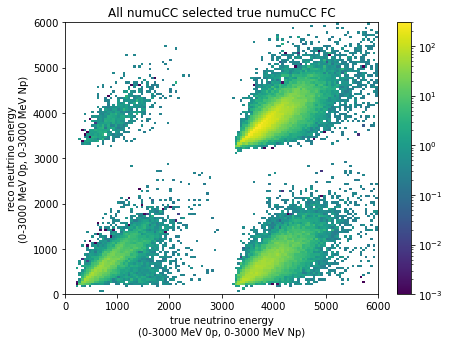

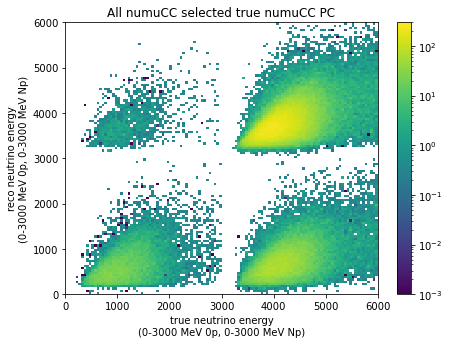

In [20]:
b = (60, 60)
r = ((0, 3000), (0, 3000))

res_true_0p_reco_0p_FC_raw, xedges_, yedges_ = np.histogram2d(numu_true_0p_reco_0p_FC_df["truth_nuEnergy"].to_numpy(), numu_true_0p_reco_0p_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_0p_reco_0p_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_0p_reco_Np_FC_raw, xedges_, yedges_ = np.histogram2d(numu_true_0p_reco_Np_FC_df["truth_nuEnergy"].to_numpy(), numu_true_0p_reco_Np_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_0p_reco_Np_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_0p_FC_raw, xedges_, yedges_ = np.histogram2d(numu_true_Np_reco_0p_FC_df["truth_nuEnergy"].to_numpy(), numu_true_Np_reco_0p_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_Np_reco_0p_FC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_Np_FC_raw, xedges_, yedges_ = np.histogram2d(numu_true_Np_reco_Np_FC_df["truth_nuEnergy"].to_numpy(), numu_true_Np_reco_Np_FC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_Np_reco_Np_FC_df["net_weight"].to_numpy(), bins=b, range=r)

res_true_0p_reco_0p_PC_raw, xedges_, yedges_ = np.histogram2d(numu_true_0p_reco_0p_PC_df["truth_nuEnergy"].to_numpy(), numu_true_0p_reco_0p_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_0p_reco_0p_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_0p_reco_Np_PC_raw, xedges_, yedges_ = np.histogram2d(numu_true_0p_reco_Np_PC_df["truth_nuEnergy"].to_numpy(), numu_true_0p_reco_Np_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_0p_reco_Np_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_0p_PC_raw, xedges_, yedges_ = np.histogram2d(numu_true_Np_reco_0p_PC_df["truth_nuEnergy"].to_numpy(), numu_true_Np_reco_0p_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_Np_reco_0p_PC_df["net_weight"].to_numpy(), bins=b, range=r)
res_true_Np_reco_Np_PC_raw, xedges_, yedges_ = np.histogram2d(numu_true_Np_reco_Np_PC_df["truth_nuEnergy"].to_numpy(), numu_true_Np_reco_Np_PC_df["kine_reco_Enu"].to_numpy(), 
                                                     weights=numu_true_Np_reco_Np_PC_df["net_weight"].to_numpy(), bins=b, range=r)

nueCC_FC_split_res = []
nueCC_PC_split_res = []
bin_centers_x = []
bin_centers_y = []

# true 0p reco 0p
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_0p_reco_0p_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_0p_reco_0p_PC_raw[i][j])
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)

# true 0p reco Np
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_0p_reco_Np_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_0p_reco_Np_PC_raw[i][j])
        bin_centers_x.append((i + 0.5) / 60. * 3000.)
        bin_centers_y.append(3000. + (j + 0.5) / 60. * 3000.)
        
# true Np reco 0p
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_Np_reco_0p_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_Np_reco_0p_PC_raw[i][j])
        bin_centers_x.append(3000. + (i + 0.5) / 60. * 3000.)
        bin_centers_y.append((j + 0.5) / 60. * 3000.)

# true Np reco Np
for i in range(60):
    for j in range(60):
        nueCC_FC_split_res.append(res_true_Np_reco_Np_FC_raw[i][j])
        nueCC_PC_split_res.append(res_true_Np_reco_Np_PC_raw[i][j])
        bin_centers_x.append(3000. + (i + 0.5) / 60. * 3000.)
        bin_centers_y.append(3000. + (j + 0.5) / 60. * 3000.)


print(np.max(nueCC_FC_split_res), np.max(nueCC_PC_split_res))

b = (120, 120)
r = ((0, 6000), (0, 6000))

mpl.rcParams.update({'font.size': 10})

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_FC_split_res, norm=mpl.colors.LogNorm(1e-3, 300))
plt.colorbar()
plt.xlabel("true neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.ylabel("reco neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.title("All numuCC selected true numuCC FC")
plt.savefig("plots/numu_FC_res.png", dpi=600)
plt.show()

plt.figure(figsize=(7,5))
plt.hist2d(bin_centers_x, bin_centers_y, bins=b, range=r, weights=nueCC_PC_split_res, norm=mpl.colors.LogNorm(1e-3, 300))
plt.colorbar()
plt.xlabel("true neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.ylabel("reco neutrino energy\n(0-3000 MeV 0p, 0-3000 MeV Np)")
plt.title("All numuCC selected true numuCC PC")
plt.savefig("plots/numu_PC_res.png", dpi=600)
plt.show()


In [21]:
# getting Xp numbers from previous data release
# copied from generate_text.ipynb
# new things have to match this exactly

nueFC_background = [
    0.00,
    1.64,
    2.13,
    4.99,
    3.66,
    6.57,
    5.87,
    4.84,
    3.99,
    2.28,
    3.51,
    1.47,
    2.22,
    2.34,
    1.98,
    1.65,
    2.03,
    1.39,
    0.82,
    1.16,
    1.57,
    0.75,
    0.87,
    1.11,
    0.56,
    5.19,
]    

nueFC_signal = [
     0.03,
     0.75,
     3.60,
     7.85,
    12.84,
    17.48,
    20.34,
    21.39,
    22.00,
    21.75,
    21.78,
    19.67,
    18.87,
    16.94,
    15.75,
    14.11,
    12.39,
    12.22,
    10.39,
     9.01,
     7.96,
     7.24,
     6.12,
     5.57,
     4.82,
    27.15,
]

nuePC_background = [
    0.00,
    0.34,
    2.54,
    1.22,
    0.77,
    2.03,
    2.68,
    3.90,
    1.78,
    2.29,
    2.53,
    2.68,
    2.42,
    1.85,
    1.60,
    2.55,
    2.03,
    2.51,
    1.65,
    1.59,
    1.07,
    2.32,
    1.30,
    0.91,
    1.45,
    9.98,
]

nuePC_signal = [
     0.00,
     0.47,
     1.81,
     3.67,
     6.41,
     8.15,
     9.64,
    10.90,
    12.03,
    11.98,
    11.07,
    11.56,
    10.60,
     9.93,
     9.30,
     8.44,
     7.62,
     7.39,
     6.87,
     5.84,
     5.83,
     4.96,
     4.25,
     3.74,
     3.26,
    21.76,
]    

numuFC_background = [
      2.81,
      7.17,
    158.85,
    370.86,
    501.18,
    551.64,
    552.78,
    475.03,
    419.69,
    355.69,
    299.34,
    244.17,
    198.27,
    156.30,
    137.38,
     96.38,
     63.56,
     45.37,
     35.67,
     32.55,
     19.73,
     19.24,
     12.95,
     10.08,
      9.30,
     54.57,
]    

numuFC_signal = [
       1.09,
      10.23,
     783.85,
    2265.85,
    3480.27,
    4102.25,
    4384.92,
    4107.73,
    3488.79,
    2787.53,
    2136.44,
    1646.03,
    1126.66,
     741.78,
     519.47,
     375.63,
     220.00,
     137.87,
     114.58,
      72.31,
      40.53,
      23.32,
      16.20,
      14.92,
       7.39,
      34.26,
]    

numuPC_background = [
      10.08,
      35.15,
     338.62,
     656.57,
     915.63,
    1027.43,
    1056.02,
    1011.42,
     929.12,
     774.05,
     644.26,
     525.00,
     413.65,
     319.93,
     268.89,
     221.38,
     161.93,
     132.04,
     107.41,
      98.22,
      75.42,
      65.86,
      62.39,
      49.44,
      41.50,
     280.66,
]    

numuPC_signal = [
        9.58,
      169.97,
     2274.28,
     5800.05,
     8867.03,
    10132.36,
     9893.77,
     8879.55,
     7301.43,
     5780.96,
     4418.41,
     3111.43,
     2250.19,
     1601.66,
     1042.59,
      782.16,
      551.53,
      391.59,
      288.62,
      204.60,
      158.92,
      126.92,
       91.07,
       75.38,
       57.04,
      233.78,
]    

CCpi0FC_background = [
    268.43,
    181.14,
    110.64,
     69.97,
     53.37,
     28.87,
     18.11,
     12.55,
      9.55,
      5.20,
     33.47,
]    

CCpi0FC_signal = [
    783.91,
    622.73,
    409.42,
    227.99,
    117.62,
     69.70,
     34.52,
     25.33,
     16.78,
      9.02,
     42.26,
]    

CCpi0PC_background = [
    534.76,
    375.93,
    230.84,
    168.51,
    103.27,
     62.68,
     40.75,
     24.34,
     21.49,
     18.49,
     66.82,
]    

CCpi0PC_signal = [
    1383.31,
    1047.79,
     702.69,
     368.03,
     194.61,
     106.49,
      70.89,
      39.17,
      30.94,
      24.93,
      98.86,
]

NCpi0_background = [
    1451.54,
     720.02,
     452.24,
     301.57,
     229.03,
     144.64,
      88.60,
      56.93,
      38.10,
      35.64,
     169.83,
]    

NCpi0_signal = [
    1034.49,
     714.90,
     486.48,
     270.34,
     158.90,
      77.79,
      52.05,
      25.51,
      15.19,
      14.29,
      60.12,
]

nueFC_data = [
    0,
    5,
    6,
    12,
    19,
    14,
    18,
    24,
    25,
    22,
    29,
    18,
    16,
    18,
    15,
    20,
    12,
    13,
    9,
    5,
    9,
    10,
    4,
    7,
    8,
    30,
]

nuePC_data = [
     0,
     2,
     8,
     5,
     8,
    14,
     6,
    19,
    23,
    14,
    20,
    12,
    14,
    11,
    10,
    14,
     8,
     6,
     5,
     6,
     2,
     7,
     0,
     3,
     2,
    19,
]


numuFC_data = [
       6,
      20,
    1068,
    3086,
    4830,
    5603,
    5753,
    5292,
    4331,
    3448,
    2555,
    1833,
    1246,
     765,
     534,
     332,
     196,
     138,
      89,
      42,
      37,
      30,
      30,
      14,
      12,
      52,
]

numuPC_data = [
       22,
      282,
     3281,
     7647,
    11276,
    12536,
    11876,
    10433,
     8541,
     6501,
     4823,
     3484,
     2330,
     1653,
     1075,
      726,
      539,
      388,
      252,
      181,
      163,
      115,
      111,
       76,
       60,
      308,
]


seven_ch_background_from_past_release = (nueFC_background + nuePC_background
                                         + numuFC_background + numuPC_background)
                                         #+ CCpi0FC_background + CCpi0PC_background + NCpi0_background)

seven_ch_signal_from_past_release = (nueFC_signal + nuePC_signal
                                         + numuFC_signal + numuPC_signal)
                                         #+ CCpi0FC_signal + CCpi0PC_signal + NCpi0_signal)
    
seven_ch_data_from_past_release = (nueFC_data + nuePC_data + numuFC_data + numuPC_data)

pi0_totals = np.array(CCpi0FC_background + CCpi0PC_background + NCpi0_background) + np.array(CCpi0FC_signal + CCpi0PC_signal + NCpi0_signal)

seven_ch_total_from_past_release = np.array(seven_ch_background_from_past_release) + np.array(seven_ch_signal_from_past_release)



In [22]:
with open("../xiangpan_text_files/results/data_nueCC_0p_FC_both_new.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    nue0pFC_data = [int(split[1]) for split in splits]
    nue0pFC_pred = [float(split[2]) for split in splits]
    nue0pFC_pred_lee = [float(split[3]) for split in splits]
with open("../xiangpan_text_files/results/data_nueCC_0p_PC_both_new.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    nue0pPC_data = [int(split[1]) for split in splits]
    nue0pPC_pred = [float(split[2]) for split in splits]
    nue0pPC_pred_lee = [float(split[3]) for split in splits]
with open("../xiangpan_text_files/results/data_nueCC_Np_FC_both_new.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    nueNpFC_data = [int(split[1]) for split in splits]
    nueNpFC_pred = [float(split[2]) for split in splits]
    nueNpFC_pred_lee = [float(split[3]) for split in splits]
with open("../xiangpan_text_files/results/data_nueCC_Np_PC_both_new.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    nueNpPC_data = [int(split[1]) for split in splits]
    nueNpPC_pred = [float(split[2]) for split in splits]
    nueNpPC_pred_lee = [float(split[3]) for split in splits]
    
with open("../xiangpan_text_files/results/data_numuCC_0p_FC.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    numu0pFC_data = [int(split[1]) for split in splits]
    numu0pFC_pred = [float(split[2]) for split in splits]
with open("../xiangpan_text_files/results/data_numuCC_0p_PC.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    numu0pPC_data = [int(split[1]) for split in splits]
    numu0pPC_pred = [float(split[2]) for split in splits]
with open("../xiangpan_text_files/results/data_numuCC_Np_FC.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    numuNpFC_data = [int(split[1]) for split in splits]
    numuNpFC_pred = [float(split[2]) for split in splits]
with open("../xiangpan_text_files/results/data_numuCC_Np_PC.txt") as f:
    lines = f.readlines()
    splits = [line.split() for line in lines]
    numuNpPC_data = [int(split[1]) for split in splits]
    numuNpPC_pred = [float(split[2]) for split in splits]

eleven_channel_total_from_new_release = np.array(nue0pFC_pred + nue0pPC_pred + nueNpFC_pred + nueNpPC_pred
                        + numu0pFC_pred + numu0pPC_pred + numuNpFC_pred + numuNpPC_pred)
                        #+ list(pi0_totals))
    
eleven_channel_data_from_new_release = np.array(nue0pFC_data + nue0pPC_data + nueNpFC_data + nueNpPC_data
                        + numu0pFC_data + numu0pPC_data + numuNpFC_data + numuNpPC_data)


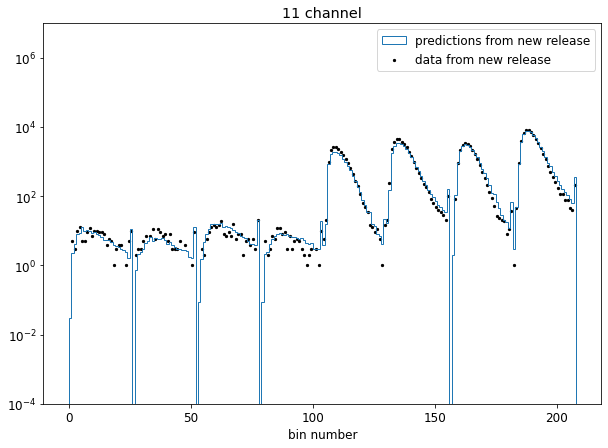

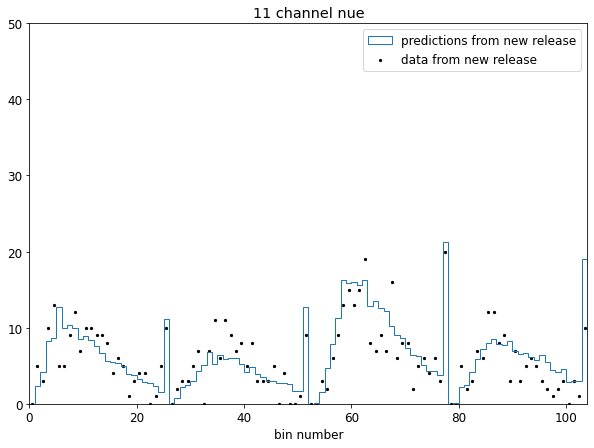

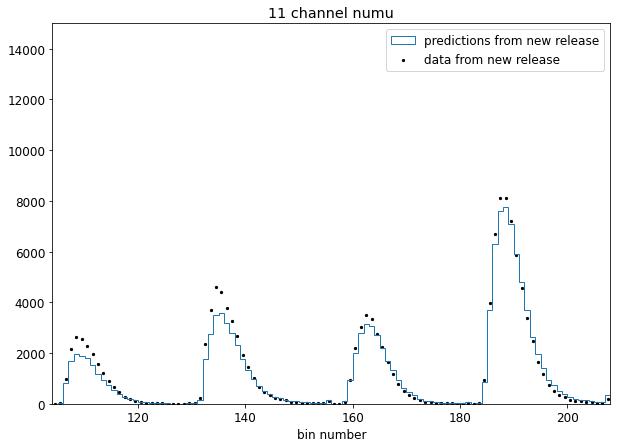

In [23]:
num_bins = 26*8
bin_centers = [0.5 + _ for _ in range(num_bins)]

mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(10,7))
plt.hist(bin_centers, weights=eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", label="predictions from new release")
plt.scatter(bin_centers, eleven_channel_data_from_new_release, label="data from new release", c="k", s=5)
plt.title("11 channel")
plt.xlabel("bin number")
plt.legend()
plt.ylim((1e-4, 1e7))
plt.yscale("log")
plt.savefig("plots/eleven_channel.png", dpi=600)
plt.show()

plt.figure(figsize=(10,7))
plt.hist(bin_centers, weights=eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", label="predictions from new release")
plt.scatter(bin_centers, eleven_channel_data_from_new_release, label="data from new release", c="k", s=5)
plt.title("11 channel nue")
plt.xlabel("bin number")
plt.legend()
plt.xlim((0, 26*4))
plt.ylim((0,50))
plt.savefig("plots/eleven_channel_nue.png", dpi=600)
plt.show()

plt.figure(figsize=(10,7))
plt.hist(bin_centers, weights=eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", label="predictions from new release")
plt.scatter(bin_centers, eleven_channel_data_from_new_release, label="data from new release", c="k", s=5)
plt.title("11 channel numu")
plt.xlabel("bin number")
plt.legend()
plt.xlim((26*4, 26*8))
plt.ylim((0,15000))
plt.savefig("plots/eleven_channel_numu.png", dpi=600)
plt.show()


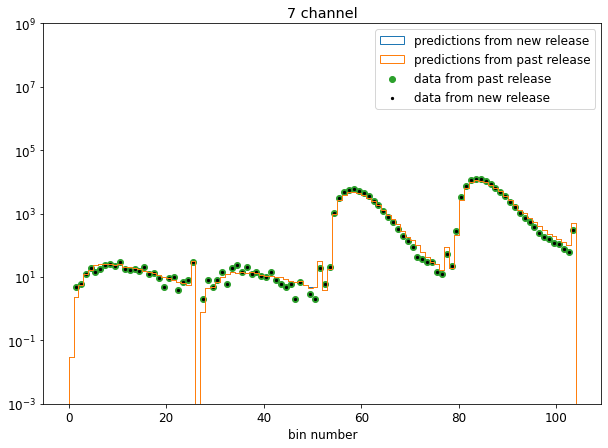

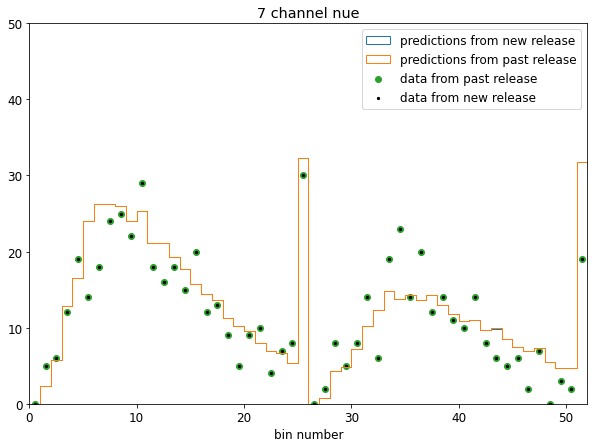

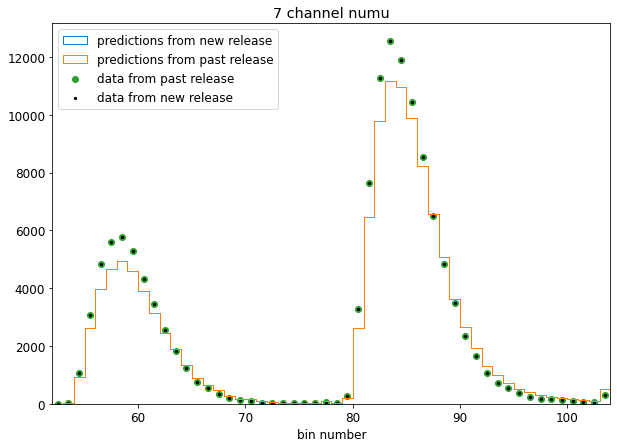

In [27]:
num_bins = 26*4
bin_centers = [0.5 + _ for _ in range(num_bins)]

collapsed_eleven_channel_total_from_new_release = []
collapsed_eleven_channel_total_from_new_release += list(eleven_channel_total_from_new_release[0:26] + eleven_channel_total_from_new_release[26*2:26*3])
collapsed_eleven_channel_total_from_new_release += list(eleven_channel_total_from_new_release[26:26*2] + eleven_channel_total_from_new_release[26*3:26*4])
collapsed_eleven_channel_total_from_new_release += list(eleven_channel_total_from_new_release[26*4:26*5] + eleven_channel_total_from_new_release[26*6:26*7])
collapsed_eleven_channel_total_from_new_release += list(eleven_channel_total_from_new_release[26*5:26*6] + eleven_channel_total_from_new_release[26*7:26*8])
collapsed_eleven_channel_total_from_new_release += list(eleven_channel_total_from_new_release[26*8:])
collapsed_eleven_channel_total_from_new_release = np.array(collapsed_eleven_channel_total_from_new_release)

collapsed_eleven_channel_data_from_new_release = []
collapsed_eleven_channel_data_from_new_release += list(eleven_channel_data_from_new_release[0:26] + eleven_channel_data_from_new_release[26*2:26*3])
collapsed_eleven_channel_data_from_new_release += list(eleven_channel_data_from_new_release[26:26*2] + eleven_channel_data_from_new_release[26*3:26*4])
collapsed_eleven_channel_data_from_new_release += list(eleven_channel_data_from_new_release[26*4:26*5] + eleven_channel_data_from_new_release[26*6:26*7])
collapsed_eleven_channel_data_from_new_release += list(eleven_channel_data_from_new_release[26*5:26*6] + eleven_channel_data_from_new_release[26*7:26*8])
collapsed_eleven_channel_data_from_new_release += list(eleven_channel_data_from_new_release[26*8:])
collapsed_eleven_channel_data_from_new_release = np.array(collapsed_eleven_channel_data_from_new_release)

mpl.rcParams.update({'font.size': 12})

plt.figure(figsize=(10,7))

plt.hist(bin_centers, weights=collapsed_eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from new release")
plt.hist(bin_centers, weights=seven_ch_total_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from past release")
#plt.hist(bin_centers, weights=seven_ch_signal_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="total signal prediction from past release")
#plt.hist(bin_centers, weights=seven_ch_background_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="background prediction from past release")
plt.scatter(bin_centers, seven_ch_data_from_past_release, label="data from past release")
plt.scatter(bin_centers, collapsed_eleven_channel_data_from_new_release, s=5, c="k", label="data from new release")

plt.title("7 channel")
plt.xlabel("bin number")
plt.yscale("log")
plt.ylim((1e-3, 1e9))
plt.legend()
#plt.ylim((0, 20))
plt.savefig("plots/seven_channel.png", dpi=600)
plt.show()

plt.figure(figsize=(10,7))

plt.hist(bin_centers, weights=collapsed_eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from new release")
plt.hist(bin_centers, weights=seven_ch_total_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from past release")
#plt.hist(bin_centers, weights=seven_ch_signal_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="total signal prediction from past release")
#plt.hist(bin_centers, weights=seven_ch_background_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="background prediction from past release")
plt.scatter(bin_centers, seven_ch_data_from_past_release, label="data from past release")
plt.scatter(bin_centers, collapsed_eleven_channel_data_from_new_release, s=5, c="k", label="data from new release")

plt.title("7 channel nue")
plt.xlabel("bin number")
plt.xlim(0, 26*2)
plt.ylim((0, 50))
plt.legend()
#plt.ylim((0, 20))
plt.savefig("plots/seven_channel_nue.png", dpi=600)

plt.show()


plt.figure(figsize=(10,7))

plt.hist(bin_centers, weights=collapsed_eleven_channel_total_from_new_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from new release")
plt.hist(bin_centers, weights=seven_ch_total_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
         label="predictions from past release")
#plt.hist(bin_centers, weights=seven_ch_signal_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="total signal prediction from past release")
#plt.hist(bin_centers, weights=seven_ch_background_from_past_release, bins=num_bins, range=(0, num_bins), histtype="step", 
#         label="background prediction from past release")
plt.scatter(bin_centers, seven_ch_data_from_past_release, label="data from past release")
plt.scatter(bin_centers, collapsed_eleven_channel_data_from_new_release, s=5, c="k", label="data from new release")

plt.title("7 channel numu")
plt.xlabel("bin number")
plt.xlim(26*2, 26*4)
#plt.ylim((0, 50))
plt.legend()
#plt.ylim((0, 20))
plt.savefig("plots/seven_channel_numu.png", dpi=600)
plt.show()


In [40]:
covariance_matrices = []

for lee_times_ten in range(21):
    lee_times_ten_text = str(lee_times_ten).zfill(2)
    covariance_matrices.append(np.genfromtxt(f"../xiangpan_text_files/results/systematicsCOV_LEEx_{lee_times_ten_text}.txt"))



In [41]:
covariance_matrices[0].shape

(241, 241)

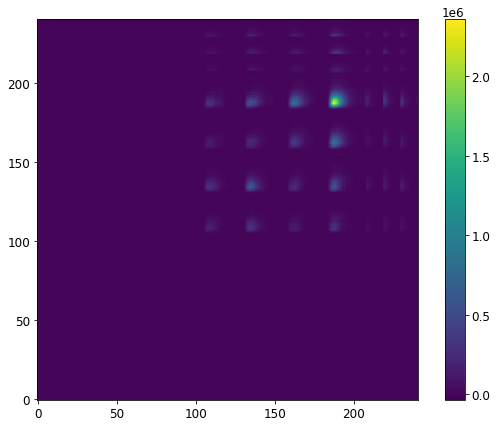

In [62]:
plt.figure(figsize=(10,7))

#plt.imshow(covariance_matrices[0], origin="lower", norm=mpl.colors.LogNorm(vmin=np.min(covariance_matrices[0]), vmax=np.max(covariance_matrices[0])))
plt.imshow(covariance_matrices[0], origin="lower")
plt.colorbar()
plt.savefig("plots/covariance_00.png")
plt.show()